# Advanced: Control your flow

Here we dive a bit deeper in advanced flow control in Noodles. Starting with a recap into for-loops, moving on to conditional evaluation of workflows and standard algorithms. This chapter will  also go a bit deeper into the teritory of functional programming. Specifically, we will see how to program sequential loops using only functions and recursion.

If you are new to the concepts of *recursion*, here is some nice material to start with:

[![Socratia - Recursion, Fibonacci Sequence and Memoization](https://img.youtube.com/vi/Qk0zUZW-U_M/0.jpg)](https://www.youtube.com/watch?v=Qk0zUZW-U_M)

## Recap: for loops
In the *Translating Poetry* tutorial we saw how we could create parallel `for` loops in Noodles. To recap, let's assume you have the following for-loop in Python:

In [1]:
sentence = 'the quick brown fox jumps over the lazy dog'
reverse = []

def reverse_word(word):
    return word[::-1]

for word in sentence.split():
    reverse.append(reverse_word(word))
    
result = ' '.join(reverse)
print(result)

eht kciuq nworb xof spmuj revo eht yzal god


There is a pattern to this code that is better written as:

In [2]:
reverse = [reverse_word(word) for word in sentence.split()]
result = ' '.join(reverse)
print(result)

eht kciuq nworb xof spmuj revo eht yzal god


This last version can be translated to Noodles. Assume for some reason we want to schedule the `reverse_word` function (it takes forever to run!). Because `reverse_words` becomes a *promise*, the line with `' '.join(reverse)` also has to be captured in a scheduled function.

In [3]:
import noodles

@noodles.schedule
def reverse_word(word):
    return word[::-1]

@noodles.schedule
def make_sentence(words):
    return ' '.join(words)

reverse_words = noodles.gather_all(
    reverse_word(word) for word in sentence.split())
workflow = make_sentence(reverse_words)

In [4]:
from noodles.tutorial import display_workflows
noodles.tutorial.display_workflows(prefix='control', quick_brown_fox=workflow)

| quick_brown_fox |
| --- |
| ![workflow quick_brown_fox](control-quick_brown_fox.svg) |

But Python has more statements for flow control! The conditional execution of code is regulated through the `if` statement. You may want to make the exection of parts of your workflow conditional based on intermediate results. One such instance may look like this:

In [5]:
@noodles.schedule
def method_one(x):
    pass

@noodles.schedule
def method_two(x):
    pass

@noodles.schedule
def what_to_do(x):
    if condition(x):
        return method_one(x)
    else:
        return method_two(x)

We've put the `if`-statement inside the scheduled function `what_to_do`. This returns a new workflow depending on the value of `x`. We can no longer get a nice single graph picture of the workflow, because the workflow doesn't exist! (there is no spoon ...) We can work through a small example from the Python tutorial: computing prime numbers.

In [6]:
for n in range(2, 10):
    for x in range(2, n):
        if n % x == 0:
            print(n, 'equals', x, '*', n//x)
            break
    else:
        # loop fell through without finding a factor
        print(n, 'is a prime number')

2 is a prime number
3 is a prime number
4 equals 2 * 2
5 is a prime number
6 equals 2 * 3
7 is a prime number
8 equals 2 * 4
9 equals 3 * 3


The core computation in this example is the `n % x == 0` bit. So we start by creating a scheduled function that does that.

In [7]:
@noodles.schedule
def divides(n, x):
    return n % x == 0

Noodles can parallelize the inner loop, but this gives a problem: how do we know when to stop? There is no way to get it both ways. Either we write a loop in parallel, Noodles evaluates all items, and we find out later we needed only the first few; or, we have to do everything sequential. 

> There are hybrid *divide and conquer* approaches that can be implemented in Noodles. We then chunk all the work in blocks that can be executed in parallel, and stop when the first chunk gives us reason to. Divide-and-conquer can be implemented using a combination of the two looping strategies (parallel and sequential).

First, we'll see how to do the parallel solution. We'll compute the `divides(n, x)` function for the values of `n` and `x` and then filter out those where `divides` gave `False`. This last step is done using the `compress` function.

In [8]:
@noodles.schedule
def compress(lst):
    """Takes a list of pairs, returns a list of
    first elements of those pairs for which the
    second element is thruthy."""
    return [a for a, b in lst if b]

Using the `compress` function we can write the Noodlified parallel version of the `filter` function. We'll call it `p_filter` for *parallel filter*.

In [9]:
?filter

Init signature: filter(self, /, *args, **kwargs)
Docstring:     
filter(function or None, iterable) --> filter object

Return an iterator yielding those items of iterable for which function(item)
is true. If function is None, return the items that are true.
Type:           type


Using the generic `p_filter` function we then write the function `find_factors` that finds all integer factors of a number in parallel. Both `p_filter` and `find_factors` won't be scheduled functions. Rather, together they build the workflow that solves our problem.

In [10]:
def p_filter(f, lst):
    return compress(noodles.gather_all(
        noodles.gather(x, f(x)) for x in lst))

def find_factors(n):
    return p_filter(lambda x: divides(n, x), range(2, n))

In [11]:
display_workflows(prefix='control', factors=find_factors(5))

| factors |
| --- |
| ![workflow factors](control-factors.svg) |

No we can run this workflow for all the numbers we like.

In [12]:
result = noodles.run_parallel(
    noodles.gather_all(noodles.gather(n, find_factors(n))
                       for n in range(2, 10)),
    n_threads=4)

for n, factors in result:
    if factors:
        print(n, 'equals', ', '.join(
            '{}*{}'.format(x, n//x) for x in factors))
    else:
        print(n, 'is prime')

2 is prime
3 is prime
4 equals 2*2
5 is prime
6 equals 2*3, 3*2
7 is prime
8 equals 2*4, 4*2
9 equals 3*3


Few! We managed, but if all we wanted to do is find primes, we did way too much work; we also found all factors of the numbers. We had to write some boiler plate code. Argh, this tutorial was supposed to be on flow control! We move on to the sequential version. Wait, I hear you think, we were using Noodles to do things in parallel!?? Why make an effort to do sequential work? Well, we'll need it to implement the divide-and-conquer strategy, among other things. Noodles is not only a framework for parallel programming, but it also works concurrent. In the context of a larger workflow we may still want to make decision steps on a sequential basis, while another component of the workflow is happily churning out numbers.

## Recursion

Sequential loops can be made in Noodles using recursion. Comes the obligatory factorial function example:

In [13]:
def factorial(x):
    if x == 0:
        return 1
    else:
        return factorial(x - 1) * x

factorial(100)

93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000

There is a problem with such a recursive algorithm when numbers get too high.

In [14]:
factorial(10000)

RecursionError: maximum recursion depth exceeded in comparison

Yikes! Let's head on. And translate the program to Noodles. Suppose we make `factorial` a scheduled function, we cannot multiply a *promise* with a *number* just like that (at least not in the current version of Noodles). We change the function slightly with a second argument that keeps count. This also makes the `factorial` function *tail-recursive*. 

In [ ]:
@noodles.schedule
def factorial(x, acc=1):
    if x == 0:
        return acc
    else:
        return factorial(x - 1, acc * x)
    
result = noodles.run_single(factorial(10000))
print('10000! =', str(result)[:100], '...', str(result)[-100:])

Yeah! Noodles runs the tail-recursive function iteratively! This is actually **very important**. We'll do a little experiment. Start your system monitor (plotting a graph of your memory usage) and run the following snippets. We let every function call to factorial gobble up some memory and to be able to measure the effect of that we insert a small sleep. Fair warning: With the current setting of `gobble_size` and running 50 loops, the first version will take about **4GB** of memory. Just change the size so that a measurable fraction of your RAM is taken up by the process and you can see the result.

In [83]:
import numpy as np
import time

gobble_size = 10000000

In [165]:
@noodles.schedule
def mul(x, y):
    return x*y

@noodles.schedule(call_by_ref=['gobble'])
def factorial(x, gobble=None):
    time.sleep(0.1)
    if x == 0:
        return 1
    else:
        return mul(factorial(x - 1, gobble.copy()), x)
    
gobble = np.zeros(gobble_size)
result = noodles.run_single(factorial(50, gobble=gobble))

We passed the `gobble` argument by reference. This prevents Noodles from copying the array when creating the workflow. If you have functions that take large arrays as input *and you don't change the value of the array in between calls* this is a sensible thing to do.
On my machine, running only 10 loops, this gives the following result:

![Memory usage with normal recursion](control-recursion.svg)

Try to understand why this happens. We have reserved a NumPy array with `gobble_size` ($10^7$) floating points of 8 bytes each. The total size in bytes of this array is $8 \times 10^7\ MB$. In each recursive call to `factorial` the array is copied, so in total this will use $10 \cdot 8 \times 10^7\ MB = 800\ MB$ of memory!

The next version is the tail-recursive one. This should barely make a dent in your memory usage!

In [166]:
@noodles.schedule(call_by_ref=['gobble'])
def factorial(x, acc=1, gobble=None):
    time.sleep(0.1)
    if x == 0:
        return acc
    else:
        return factorial(x - 1, acc * x, gobble.copy())

gobble = np.zeros(gobble_size)
result = noodles.run_single(factorial(50, gobble=gobble))

![Memory usage with tail recursion](control-tail-recursion.svg)

Now, the `factorial` function is still recursive. However, since returning a call to the `factorial` function is last thing we do, the intermediate results can be safely thrown away. We'll have in memory the original reference to `gobble` and one version in the Noodles run-time for the last time `factorial` returned a workflow where `gobble.copy()` was one of the arguments.
In total this gives a memory consumption of $160\ MB$ (plus a little extra for the Python run-time itself). We see peeks that reach over $250\ MB$ in the graph: this is where `gobble` is being copied, after which the garbage collector deletes the old array.

## Find-first

Previously we saw the definition of a Noodlified `filter` function. How can we write a `find_first` that stops after finding a first match? If we look at the workflow that `p_filter` produces, we see that all predicates are already present in the workflow and will be computed concurrently. We now write a sequential version. We may achieve sequential looping through recursion like this:

In [168]:
def find_first(f, lst):
    if not lst:
        return None
    elif f(lst[0]):
        return lst[0]
    else:
        return find_first(f, lst[1:])

However, if `f` is a scheduled function `f(lst[0])` will give a promise, and this routine will fail.

In [172]:
@noodles.schedule
def find_first_helper(f, lst, first):
    if first:
        return lst[0]
    elif len(lst) == 1:
        return None
    else:
        return find_first_helper(f, lst[1:], f(lst[1]))

def find_first(f, lst):
    return find_first_helper(f, lst, f(lst[0]))

In [174]:
noodles.run_single(find_first(lambda x: divides(77, x), range(2, 63)))

7

That works. Now suppose the input list is somewhat harder to compute; every element is the result of a workflow.

## Appendix: creating memory profile plots

In [142]:
%%writefile test-tail-recursion.py
import numpy as np
import noodles
import time

@noodles.schedule(call_by_ref=['gobble'])
def factorial(x, acc=1, gobble=None):
    time.sleep(0.1)
    if x == 0:
        return acc
    else:
        return factorial(x - 1, acc * x, gobble.copy())

gobble = np.zeros(10000000)
result = noodles.run_single(factorial(10, gobble=gobble))

Overwriting test-tail-recursion.py


In [143]:
%%writefile test-recursion.py
import numpy as np
import noodles
import time

@noodles.schedule
def mul(x, y):
    return x*y

@noodles.schedule(call_by_ref=['gobble'])
def factorial(x, gobble=None):
    time.sleep(0.1)
    if x == 0:
        return 1
    else:
        return mul(factorial(x - 1, gobble.copy()), x)

gobble = np.zeros(10000000)
result = noodles.run_single(factorial(10, gobble=gobble))

Overwriting test-recursion.py


In [144]:
!pip install memory_profiler

In [149]:
%%bash
rm mprofile_*.dat
mprof run -T 0.001 python ./test-tail-recursion.py
mprof run -T 0.001 python ./test-recursion.py

mprof: Sampling memory every 0.001s
mprof: Sampling memory every 0.001s


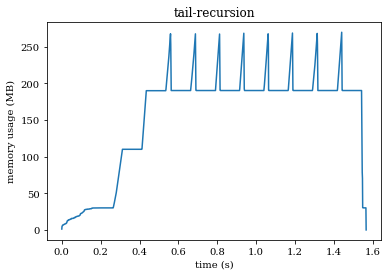

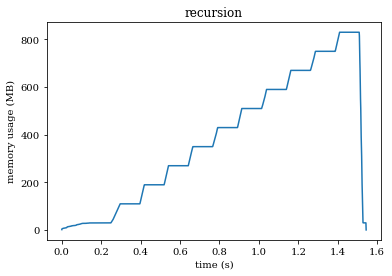

In [162]:
from pathlib import Path
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'

def read_mprof(filename):
    lines = list(open(filename, 'r'))
    cmd = filter(lambda l: l[:3] == 'CMD', lines)
    mem = filter(lambda l: l[:3] == 'MEM', lines)
    data = np.array([list(map(float, l.split()[1:])) for l in mem])
    data[:,1] -= data[0,1]
    data[:,0] *= 1024**2
    return cmd, data

def plot_mprof(filename):
    cmd, data = read_mprof(filename)
    if 'tail' in next(cmd):
        figname = 'tail-recursion'
    else:
        figname = 'recursion'
        
    plt.plot(data[:,1], data[:,0] / 1e6)
    plt.xlabel('time (s)')
    plt.ylabel('memory usage (MB)')
    plt.title(figname)
    plt.savefig('control-' + figname + '-raw.svg', bbox_inches='tight')
    plt.show()

files = list(Path('.').glob('mprofile_*.dat'))
for f in files:
    plot_mprof(f)
    plt.close()